# Credit Risk Prediction

The focus of credit risk analysis is to predict the likelihood of a borrower defaulting on their loan and also its lender's financial impact if default occurs. This analysis leverages logistic regression to answer those mentioned focus of analysis. The dataset was obtained through [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset), containing 32.581 observations and 12 variables.

#### Data description:
| Feature Name | Description  |
|---|---|
| person_age | Age |
| person_income | Annual income (\$) |
| person_home_ownership | Type of home ownership |
| person_emp_length | How long have borrowers been working (in years)? |
| loan_intent | The uses of loan |
| loan_grade | Loan grade of borrower: A (lowest risk)—F (highest risk) |
| loan_amnt | Amount of money applied ($) |
| loan_int_rate | Interest rate |
| **loan_status** | **target variable, 0: non-default; 1: default** |
| loan_percent_income | Percentage of an individual's income to pay the loan |
| cb_person_default_on_file | Historical default |
| cb_person_cred_hist_length | Credit history length |


In [232]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
import tensorflow as tf
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, \
precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

In [163]:
# Load and print the first 5 data
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [272]:
df['person_home_ownership'].value_counts()

person_home_ownership
RENT        16378
MORTGAGE    13369
OWN          2563
OTHER         106
Name: count, dtype: int64

In [165]:
# Checking null values
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [166]:
# Checking for possible duplicated value(s)
df[df.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [167]:
# Drop duplicates 
df.drop_duplicates(inplace=True)

In [168]:
#Detecting outlier using statistical tests
def outlier(df):
    result_df = pd.DataFrame(columns=['Count','Mean','Std','Min','25%', '50%','75%', '95%','Max','IQR', 'Lower Thresh', 'Upper Thresh'])
    
    for col in df.select_dtypes(include=np.number).columns: 
        count = df[col].count()
        mean = np.mean(df[col])
        std = np.std(df[col])
        min = np.min(df[col])
        q1 = df[col].quantile(.25)
        p50 = df[col].quantile(.5)
        q3 = df[col].quantile(.75)
        p95 = df[col].quantile(.95)
        max = np.max(df[col])
        iqr = q3 - q1
        lower_thresh = q1 - 1.5 * iqr
        upper_thresh = q3 + 1.5 * iqr
        
        result_df.loc[col] = [count, mean, std, min, q1, p50,q3, p95, max, iqr, lower_thresh, upper_thresh]
    
    return round(result_df,1)

outlier(df)

,Count,Mean,Std,Min,25%,50%,75%,95%,Max,IQR,Lower Thresh,Upper Thresh
person_age,32416.0,27.7,6.4,20.0,23.0,26.0,30.0,40.0,144.0,7.0,12.5,40.5
person_income,32416.0,66091.6,62014.6,4000.0,38542.0,55000.0,79218.0,138000.0,6000000.0,40676.0,-22472.0,140232.0
person_emp_length,31529.0,4.8,4.1,0.0,2.0,4.0,7.0,13.0,123.0,5.0,-5.5,14.5
loan_amnt,32416.0,9593.8,6322.6,500.0,5000.0,8000.0,12250.0,24000.0,35000.0,7250.0,-5875.0,23125.0
loan_int_rate,29321.0,11.0,3.2,5.4,7.9,11.0,13.5,16.3,23.2,5.6,-0.5,21.8
loan_status,32416.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
loan_percent_income,32416.0,0.2,0.1,0.0,0.1,0.2,0.2,0.4,0.8,0.1,-0.1,0.4
cb_person_cred_hist_length,32416.0,5.8,4.1,2.0,3.0,4.0,8.0,14.0,30.0,5.0,-4.5,15.5


In [169]:
# Create new df w/o outliers
df2 = df[(df['person_age'] <100) & (df['person_income']<6000000)&(df['person_emp_length']<=42)]
df2.shape

(31522, 12)

In [170]:
df2['loan_int_rate'] = df2['loan_int_rate'].fillna(np.mean(df2['loan_int_rate']))

In [171]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31522 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31522 non-null  int64  
 1   person_income               31522 non-null  int64  
 2   person_home_ownership       31522 non-null  object 
 3   person_emp_length           31522 non-null  float64
 4   loan_intent                 31522 non-null  object 
 5   loan_grade                  31522 non-null  object 
 6   loan_amnt                   31522 non-null  int64  
 7   loan_int_rate               31522 non-null  float64
 8   loan_status                 31522 non-null  int64  
 9   loan_percent_income         31522 non-null  float64
 10  cb_person_default_on_file   31522 non-null  object 
 11  cb_person_cred_hist_length  31522 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.1+ MB


In [172]:
df2.nunique()

person_age                      56
person_income                 4129
person_home_ownership            4
person_emp_length               35
loan_intent                      6
loan_grade                       7
loan_amnt                      749
loan_int_rate                  349
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
dtype: int64

## Data Preprocessing

In [173]:
colors = sns.color_palette('crest', n_colors=7)

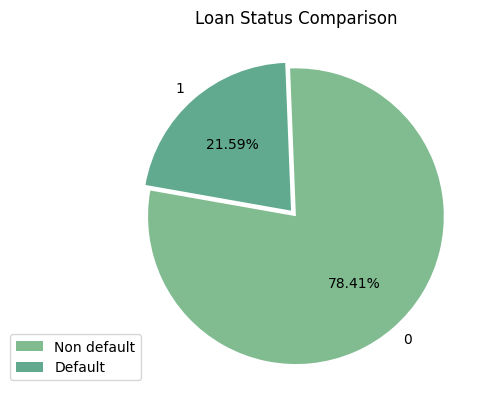

In [174]:
plt_pie = df2['loan_status'].value_counts()
plt.pie(plt_pie, labels=plt_pie.index, colors=colors,autopct='%.02f%%', explode=[0,0.05], startangle=170)
plt.title('Loan Status Comparison')
plt.legend(labels=['Non default','Default'], bbox_to_anchor=[0.1,0.2])
plt.show()

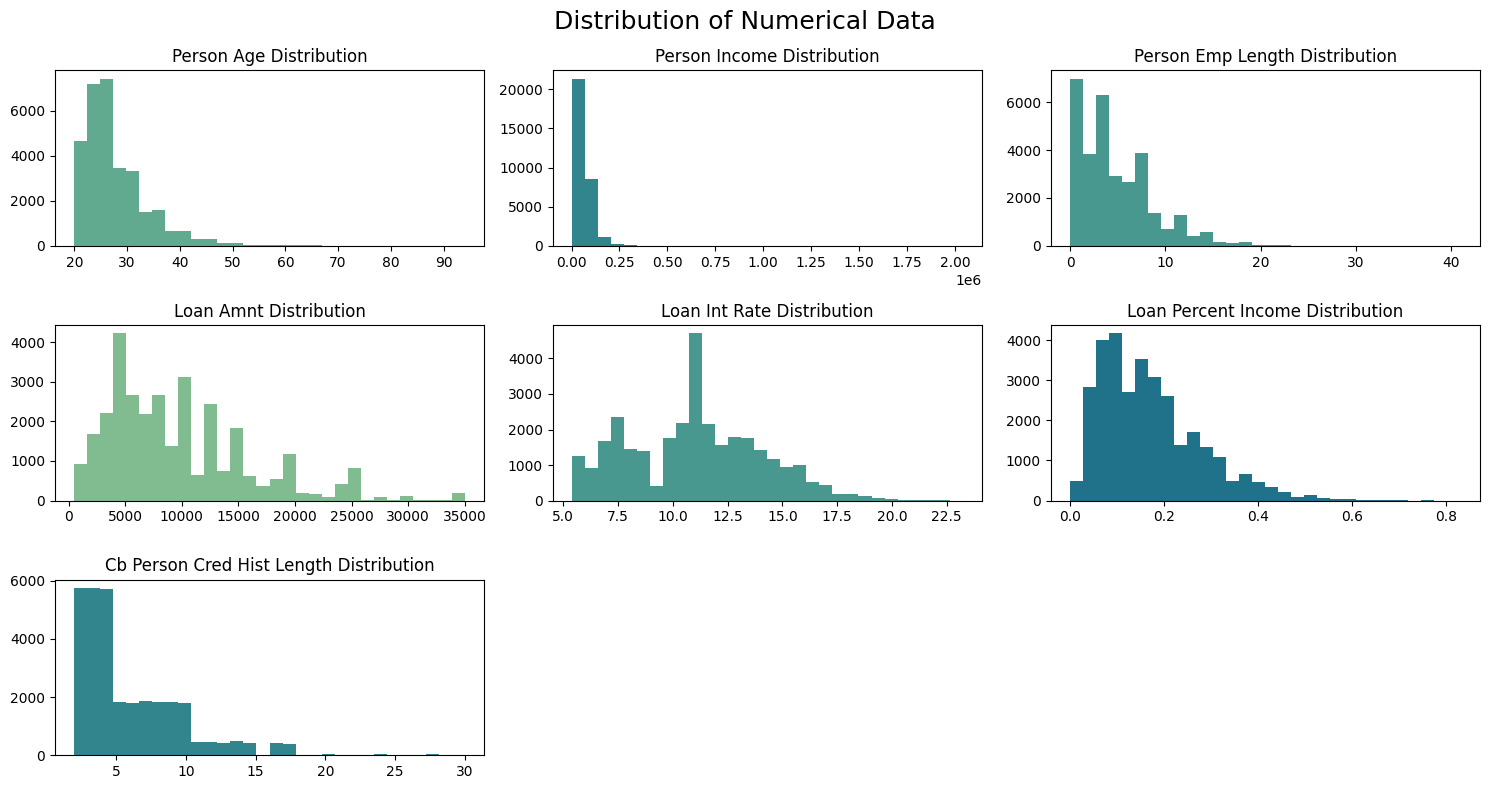

In [175]:
import random

num_var = df2.select_dtypes(include=np.number).columns.tolist()
del num_var[5]
# for excluding target variable

plt.figure(figsize=(15, 8))

for i, var in enumerate(num_var, start=1):
    plt.subplot(3, 3, i)  # row, column, position
    rand_colors = random.choice(colors)
    plt.hist(df2[var], bins=30, color=rand_colors)
    plt.title(f'{var.replace("_", " ").title()} Distribution')

plt.suptitle('Distribution of Numerical Data', fontsize=18)
plt.tight_layout()
plt.show()

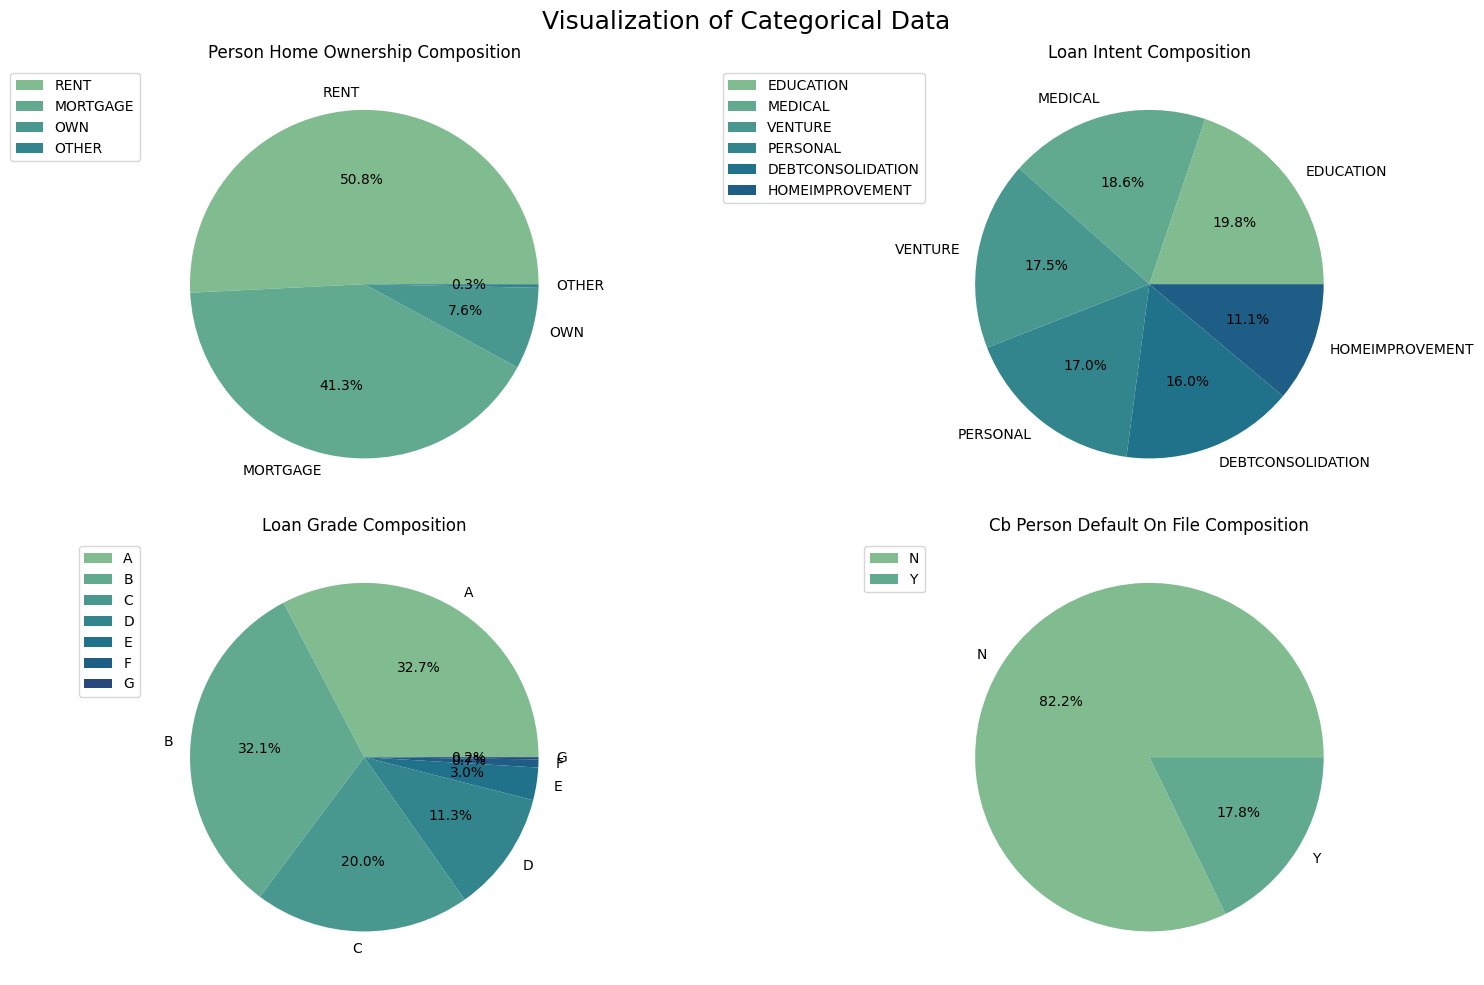

In [176]:
import random
cat_var = df2.select_dtypes(object).columns.tolist()
# del num_var[5] # for excluding target variable

plt.figure(figsize=(16, 10))

for i, var in enumerate(cat_var, start=1):
    plt_pie = df2[var].value_counts()
    plt.subplot(2, 2, i)  # row, column, position
    rand_colors = random.sample(colors, len(plt_pie))  # Random colors for each segment
    plt.pie(plt_pie, labels=plt_pie.index, colors=colors,autopct='%.1f%%')
    plt.title(f'{var.replace("_", " ").title()} Composition')
    plt.legend(bbox_to_anchor=[0,0,0,1])


plt.suptitle('Visualization of Categorical Data', fontsize=18)
plt.tight_layout()
plt.show()

In [177]:
# change the value of cb_person_default_on_file
df2['cb_person_default_on_file'] = np.where(df2['cb_person_default_on_file'] == 'Y', 1,0)

In [178]:
df2 = pd.get_dummies(df2, drop_first=True).astype(int)

In [179]:
# def label_encoder(df2):
#     cat_var = df2.select_dtypes(include=['object']).columns
#     label_encoders = {}

#     for col in cat_var:
#         le = LabelEncoder()
#         df2[col] = le.fit_transform(df2[col])
#         label_encoders[col] = le

#     return df2, label_encoders

# df2_encoded, label_encoders = label_encoder(df2)

## Build Model

### K-Nearest Neighbor

In [211]:
knn_df = df2.copy() 
X = knn_df.drop(columns='loan_status')
y = knn_df['loan_status']

In [212]:
# Split to 60% as training data and 40% to cross-val & test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [213]:
print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (25217, 22)
the shape of the training set (target) is: (25217,)

the shape of the test set (input) is: (6305, 22)
the shape of the test set (target) is: (6305,)


In [215]:
# feature scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [184]:
# fitting model
knn = KNeighborsClassifier() 
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [185]:
y_pred = knn.predict(x_test)

In [186]:
print("MODEL EVALUATION")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

MODEL EVALUATION
Accuracy: 0.8655035685963521
Confusion Matrix:
 [[4733  173]
 [ 675  724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      4906
           1       0.81      0.52      0.63      1399

    accuracy                           0.87      6305
   macro avg       0.84      0.74      0.77      6305
weighted avg       0.86      0.87      0.85      6305



In [187]:
param_grid = {'n_neighbors': list(range(1, 21))}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best k:", grid_search.best_params_['n_neighbors'])
print("Best Score:", grid_search.best_score_)

Best k: 9
Best Score: 0.8680255905477761


In [188]:
# refitting the model
best_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
best_knn.fit(x_train, y_train)

# re-evaluate with the best k
y_pred_best = best_knn.predict(x_test)
print("Accuracy with best k:", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Accuracy with best k: 0.8678826328310865
Confusion Matrix:
 [[4794  112]
 [ 721  678]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      4906
           1       0.86      0.48      0.62      1399

    accuracy                           0.87      6305
   macro avg       0.86      0.73      0.77      6305
weighted avg       0.87      0.87      0.85      6305



### Logistic Regression

In [217]:
logit_df = df2.copy() 
X = logit_df.drop(columns='loan_status')
y = logit_df['loan_status']

In [218]:
# Split to 60% as training data and 40% to cross-val & test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [219]:
# feature scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [189]:
logit = LogisticRegression()
logit.fit(x_train, y_train)

LogisticRegression()

In [190]:
y_pred = logit.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8520222045995242
Confusion Matrix:
 [[4755  151]
 [ 782  617]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      4906
           1       0.80      0.44      0.57      1399

    accuracy                           0.85      6305
   macro avg       0.83      0.71      0.74      6305
weighted avg       0.85      0.85      0.83      6305



In [191]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

print("Best C:", grid_search.best_params_['C'])
print("Best Score:", grid_search.best_score_)

Best C: 10
Best Score: 0.8514493594579087


In [192]:
best_logit = LogisticRegression(C=grid_search.best_params_['C'])
best_logit.fit(x_train, y_train)

LogisticRegression(C=10)

In [193]:
y_pred_best = best_logit.predict(x_test)
print("Accuracy with best k:", accuracy_score(y_test, y_pred_best))

Accuracy with best k: 0.8520222045995242


### XGBoost Classifier

In [224]:
import xgboost as xgb

In [264]:
xgb_df = df2.copy()
X = xgb_df.drop(columns='loan_status')
y = xgb_df['loan_status']

In [265]:
# Split to 60% as training data and 40% to cross-val & test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [266]:
xgb_clf= xgb.XGBClassifier()
#fitting the model
xgb_clf.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [267]:
# Predicting the model
y_pred = xgb_clf.predict(x_test)

In [268]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.930689928628073
Confusion Matrix:
 [[4845   61]
 [ 376 1023]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      4906
           1       0.94      0.73      0.82      1399

    accuracy                           0.93      6305
   macro avg       0.94      0.86      0.89      6305
weighted avg       0.93      0.93      0.93      6305



### Decision Trees

In [ ]:
dt_df = df2.copy() 
X = dt_df.drop(columns='loan_status')
y = dt_df['loan_status']

In [195]:
# Split to 90% as training data and 20% to test data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [196]:
decision_tree_classifier = DecisionTreeClassifier(random_state=1)
decision_tree_classifier.fit(x_train,y_train)

DecisionTreeClassifier(random_state=1)

In [197]:
y_pred = decision_tree_classifier.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8831086439333862


In [198]:
# Tuning and validation
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [199]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Score: 0.917793643971913


In [200]:
best_model = DecisionTreeClassifier(
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf']
)
best_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5)

In [201]:
y_pred_best = best_model.predict(x_test)
print("Accuracy with Best Parameters:", accuracy_score(y_test, y_pred_best))

Accuracy with Best Parameters: 0.9178429817605075


### Neural Networks

In [202]:
X = df2.drop(columns='loan_status')
y = df2['loan_status']

#### Split the Dataset

In [203]:
# Split to 60% as training data and 40% to cross-val & test data
x_train, x_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)

# From 40% split to 50% as cv data and 50% to test data
x_cv, x_test, y_cv, y_test = train_test_split(X, y, test_size=0.50, random_state=1)

del x_, y_

In [204]:
print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross-val set (input) is: {x_cv.shape}")
print(f"the shape of the cross-val set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (18913, 22)
the shape of the training set (target) is: (18913,)

the shape of the cross-val set (input) is: (15761, 22)
the shape of the cross-val set (target) is: (15761,)

the shape of the test set (input) is: (15761, 22)
the shape of the test set (target) is: (15761,)


#### Feature Scaling

In [205]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_cv = scaler.fit_transform(x_cv)
x_test = scaler.transform(x_test)

#### Build & Train the Model

In [209]:
# Define the model
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(units=32, activation='relu'),
    # tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(units=1, activation='linear')  # Change to sigmoid for binary classification
])

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(units=32, activation='relu'),
    # tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')  # Change to sigmoid for binary classification
])

model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(units=16, activation='relu'),
    # tf.keras.layers.Dropout(0.5),  # Add dropout to reduce overfitting
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')  # Change to sigmoid for binary classification
])

models = [model1,model2,model3]

y_train = pd.Series(y_train).to_numpy().flatten()
y_cv = pd.Series(y_cv).to_numpy().flatten()
y_test = pd.Series(y_test).to_numpy().flatten()

nn_train_error = []
nn_cv_error = []

for model in models:
    
    # Compile the model
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
    )

    print(f'Training {model.name}...')
    
    # Train the model
    model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

    print('Done!\n')

    threshold = 0.5
    # Predict probabilities
    y_pred = model.predict(x_train)   
    # Convert probabilities to binary predictions
    y_pred = (y_pred > threshold).astype(int)
    train_error = np.mean(y_pred != y_train)
    nn_train_error.append(train_error)

    # Predict probabilities
    y_pred = model.predict(x_cv)   
    # Convert probabilities to binary predictions
    y_pred = (y_pred > threshold).astype(int)
    train_error = np.mean(y_pred != y_cv)
    nn_cv_error.append(train_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training sequential_77...
Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.8530 - loss: 0.3602
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.8986 - loss: 0.2798
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.9018 - loss: 0.2685
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9088 - loss: 0.2501
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.9111 - loss: 0.2430
Epoch 6/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.9094 - loss: 0.2452
Epoch 7/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.9098 - loss: 0.2459
Epoch 8/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.9160 - loss: 0.2328
Epoch 9/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.9153 - loss: 0.2392
Epoch 10/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.9119 - loss: 0.2372
Epoch 11/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.9200 - loss: 0.2300
Epoc

In [210]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.70


### Save the Best Model to be Deployed

In [271]:
# Save the model
import joblib
# the best model is XGBoost
joblib.dump(xgb_clf, 'xgboost_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']